<a href="https://colab.research.google.com/github/mkatouda/qmlsample/blob/master/qiskit_qcl_regression_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Qiskitによる量子回路学習のサンプルコード: 関数の回帰問題**
量子機械学習にパラメータ化された量子回路(PQC)を適用しNISQ量子コンピュータで実行可能としたことでブレークスルーとなった手法として，大阪大学の御手洗らにより開発された量子回路学習(Quantum Cirquit Learning: QCL)が挙げられる．
本ノートブックでは，量子回路学習アルゴリズムをIBMの量子コンピューティングSDKであるQiskitを用いて実装した例を紹介する．量子回路学習アルゴリズムでは以下の手順で量子・古典ハイブリッド計算が行われる．2-4のプロセスは量子コンピュータで，1，5-6のプロセスは古典コンピュータでそれぞれ計算される．

1.   学習データ{(xi, yi), xiは入力データのベクトル, yiは出力データの真の値(教師データ)}を用意する．
2.   入力xを量子状態に埋め込む量子回路U_in(x) (特徴量マップとよぶ)を設定し，xiのデータを入力量子状態|ψ_in(xi)>=U_in(xi)|0>として埋め込む．
3.   変分最適化により調整可能なパラメータを持つ量子回路U_out(θ)を設定し，入力量子状態に作用させ，出力量子業態|ψ_out(xi, θ)>= U_out(θ)|ψ_in(xi)>を得る．
4.   出力量子状態に対し観測量の演算子を設定し，その観測量の測定値y(xi,θ)を得る．
5.   真の値yiと測定値y(xi,θ)間の乖離を表すコスト関数L(θ)を設定し，その値を極小化する方向に向かうθの候補値に更新する．
6.   3-5のプロセスを繰り返し，コスト関数L(θ)を最小化するパラメータθminを探索する．探索により得られたパラメータθminを用いたy(xi,θmin)を予測モデルとして採用する．


qiskitのインストール

In [1]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


必要なモジュールをインポート

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.algorithms.optimizers import COBYLA

QCLモデルの入力パラメータの設定


In [3]:
########  パラメータ  #############
# 乱数のシード
random_seed = 0
# 乱数発生器の初期化
np.random.seed(random_seed)

# Qubit数，回路の深さ，期待値の増幅係数
nqubit = 2
c_depth = 5
Mfac = 2.0

# 量子シミュレータの設定
num_shots = 8192

# パラメータオプティマイザの設定
maxiter = 100
tol = 0.05

回帰するデータの設定

In [4]:
########  学習データ  #############
# 回帰する関数の定義
#func_to_learn = lambda x: x**3
func_to_learn = lambda x: np.sin(x*np.pi)

# 回帰データの設定
x_min = -1.; x_max = 1.; num_x_train = 100
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

x_pred = np.arange(x_min, x_max, 0.02)
y_pred = func_to_learn(x_pred)

# 関数に正規分布ノイズを付加
mag_noise = 0.05
y_train += mag_noise * np.random.randn(num_x_train)

回帰データの可視化

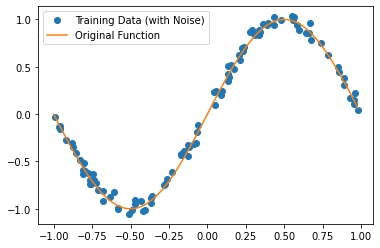

In [5]:
fig = plt.figure()
plt.plot(x_train, y_train, "o", label='Training Data (with Noise)')
plt.plot(x_pred, y_pred, label='Original Function')
plt.legend()
plt.show()
#plt.savefig('./inputdata-plot.png')

入力回路U_in(x)の設定


In [6]:
def U_in(x, nqubit):
    qr = QuantumRegister(nqubit)
    U = QuantumCircuit(qr)

    for j in range(2):
        for i in range(nqubit):
            U.ry(x, i)
            U.rz(x, i)
        for i in range(nqubit-1):
            U.cz(i, i+1)
        if nqubit >=3: U.cz(nqubit-1, 0)

    U.name = "U_in"
    return U

U_in(x_train[0], nqubit).draw()

┌──────────────┐┌──────────────┐   ┌──────────────┐┌──────────────┐   
q0_0: ┤ Ry(0.097627) ├┤ Rz(0.097627) ├─■─┤ Ry(0.097627) ├┤ Rz(0.097627) ├─■─
      ├──────────────┤├──────────────┤ │ ├──────────────┤├──────────────┤ │ 
q0_1: ┤ Ry(0.097627) ├┤ Rz(0.097627) ├─■─┤ Ry(0.097627) ├┤ Rz(0.097627) ├─■─
      └──────────────┘└──────────────┘   └──────────────┘└──────────────┘

出力回路U_out(θ)の設定

In [7]:
def U_out(nqubit, c_depth, params):
    qr = QuantumRegister(nqubit)
    U = QuantumCircuit(qr)

    for d in range(c_depth):
        for i in range(nqubit-1):
            U.cz(i, i+1)
        if nqubit >=3: U.cz(nqubit-1, 0)
        for i in range(nqubit):
            U.rx(params[nqubit*3*d+3*i], i)
            U.rz(params[nqubit*3*d+3*i+1], i)
            U.rx(params[nqubit*3*d+3*i+2], i)

    U.name = "U_out"
    return U

量子回路学習モデルの設定

In [8]:
def pred_circ(x, nqubit, c_depth, params):
    qr = QuantumRegister(nqubit, name='q')
    cr = ClassicalRegister(1, name='c')
    qc = QuantumCircuit(qr, cr)
    u_in = U_in(x, nqubit).to_instruction()
    u_out = U_out(nqubit, c_depth, params).to_instruction()
    qc.append(u_in, qr)
    qc.append(u_out, qr)
    qc.measure(0, 0)

    return qc

def get_expval(qc, Mfac, backend, num_shots):
    qc = transpile(qc, backend=backend)
    result = backend.run(qc, shots=num_shots).result()
    counts = result.get_counts(qc)
    exp_mZ = Mfac * (counts['0'] - counts['1']) / num_shots

    return exp_mZ

def qcl_reg(x_pred, nqubit, c_depth, params, Mfac, backend, num_shots):
    y_pred = []
    for x in x_pred:
        qc = pred_circ(x, nqubit, c_depth, params)
        y_pred.append(get_expval(qc, Mfac, backend, num_shots))

    return np.array(y_pred)

出力回路U_out(θ)の変分回路パラメータθの初期化

In [9]:
num_vars = 3 * nqubit * c_depth
params = np.random.rand(num_vars) * 2 * np.pi
print('initial params', params)
U_out(nqubit, c_depth, params).draw()
pred_circ(x_train[0], nqubit, c_depth, params).decompose().draw()

initial params [1.30357293 2.6683775  2.35097932 2.9127303  1.74439261 3.68687478
 5.42776485 0.73847443 3.2507888  0.82980839 4.50416222 2.48851651
 3.55264688 1.15158117 0.91010531 3.06654805 2.23438073 5.90890818
 4.80868039 4.70399226 5.67823859 0.52415862 3.46952761 3.67237145
 6.04402452 1.83561705 1.51317185 0.63016542 0.10323041 5.84040495]


┌──────────────┐┌──────────────┐   ┌──────────────┐┌──────────────┐      »
q_0: ┤ Ry(0.097627) ├┤ Rz(0.097627) ├─■─┤ Ry(0.097627) ├┤ Rz(0.097627) ├─■──■─»
     ├──────────────┤├──────────────┤ │ ├──────────────┤├──────────────┤ │  │ »
q_1: ┤ Ry(0.097627) ├┤ Rz(0.097627) ├─■─┤ Ry(0.097627) ├┤ Rz(0.097627) ├─■──■─»
     └──────────────┘└──────────────┘   └──────────────┘└──────────────┘      »
c: 1/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«     ┌────────────┐┌────────────┐┌───────────┐     ┌────────────┐»
«q_0: ┤ Rx(1.3036) ├┤ Rz(2.6684) ├┤ Rx(2.351) ├──■──┤ Rx(5.4278) ├»
«     ├────────────┤├────────────┤├───────────┴┐ │ ┌┴────────────┤»
«q_1: ┤ Rx(2.9127) ├┤ Rz(1.7444) ├┤ Rx(3.6869) ├─■─┤ Rx(0.82981) ├»
«     └────────────┘└────────────┘└────────────┘   └─────────────┘»
«c: 1/════════════════════════════════════════════════════════════»
«                                                                 »
«     ┌─────────────┐┌────────────┐   ┌────────────┐┌────────────┐»
«q_0: ┤ Rz(0.73847) ├┤ Rx(3.2508) ├─■─┤ Rx(3.5526) ├┤ Rz(1.1516) ├»
«     └┬────────────┤├────────────┤ │ ├────────────┤├────────────┤»
«q_1: ─┤ Rz(4.5042) ├┤ Rx(2.4885) ├─■─┤ Rx(3.0665) ├┤ Rz(2.2344) ├»
«      └────────────┘└────────────┘   └────────────┘└────────────┘»
«c: 1/════════════════════════════════════════════════════════════»
«                                                                 »
«     ┌─────────────┐    ┌────────────┐┌───────────┐ ┌────────────┐   »
«q_0: ┤ Rx(0.91011) ├─■──┤ Rx(4.8087) ├┤ Rz(4.704) ├─┤ Rx(5.6782) ├─■─»
«     └┬────────────┤ │ ┌┴────────────┤├───────────┴┐├────────────┤ │ »
«q_1: ─┤ Rx(5.9089) ├─■─┤ Rx(0.52416) ├┤ Rz(3.4695) ├┤ Rx(3.6724) ├─■─»
«      └────────────┘   └─────────────┘└────────────┘└────────────┘   »
«c: 1/════════════════════════════════════════════════════════════════»
«                                                                     »
«      ┌───────────┐  ┌────────────┐┌────────────┐┌─┐
«q_0: ─┤ Rx(6.044) ├──┤ Rz(1.8356) ├┤ Rx(1.5132) ├┤M├
«     ┌┴───────────┴┐┌┴────────────┤├────────────┤└╥┘
«q_1: ┤ Rx(0.63017) ├┤ Rz(0.10323) ├┤ Rx(5.8404) ├─╫─
«     └─────────────┘└─────────────┘└────────────┘ ║ 
«c: 1/═════════════════════════════════════════════╩═
«                                                  0

初期化した変分回路パラメータθを用いた回帰計算実行

In [10]:
backend = Aer.get_backend("qasm_simulator")
y_pred_reg_init = qcl_reg(x_pred, nqubit, c_depth, params, Mfac, backend, num_shots)
print('y_pred_reg_init:', y_pred_reg_init)

y_pred_reg_init: [-1.93896484 -1.89257812 -1.86181641 -1.80273438 -1.74755859 -1.66845703
 -1.6015625  -1.51464844 -1.42285156 -1.33642578 -1.21484375 -1.10839844
 -1.01074219 -0.89648438 -0.77539062 -0.67578125 -0.59326172 -0.48193359
 -0.38330078 -0.25       -0.17480469 -0.07763672  0.06640625  0.13818359
  0.21777344  0.36425781  0.35546875  0.45214844  0.53222656  0.56982422
  0.64550781  0.67773438  0.70947266  0.75732422  0.82763672  0.81152344
  0.86572266  0.84765625  0.83886719  0.85400391  0.84814453  0.8046875
  0.76953125  0.79248047  0.75878906  0.71240234  0.67285156  0.60888672
  0.56835938  0.53955078  0.45458984  0.41113281  0.36816406  0.30273438
  0.23876953  0.17871094  0.09375     0.09082031  0.05517578 -0.02978516
 -0.08496094 -0.10986328 -0.16015625 -0.18505859 -0.30908203 -0.31640625
 -0.30615234 -0.39257812 -0.41748047 -0.42236328 -0.42626953 -0.43994141
 -0.48876953 -0.484375   -0.48193359 -0.48632812 -0.49804688 -0.46972656
 -0.43261719 -0.45849609 -0.4086914

変分回路パラメータ学習用のコスト関数の設定

In [11]:
def cost_function(params):
    global iter
    cost_total = 0.0
    for i in range(len(x_train)):
        qc = pred_circ(x_train[i], nqubit, c_depth, params)
        cost = (y_train[i] - get_expval(qc, Mfac, backend, num_shots))**2
        cost_total += cost

    print('Iter: %d, Cost: %f' % (iter, cost_total))
    costs.append(cost_total)
    iter += 1

    return cost_total

変分回路パラメータ学習実行：回路パラメータの最適化アルゴリズムにはCOBYLA法を使用

In [12]:
backend = Aer.get_backend("qasm_simulator")
iter = 0; costs = []
optimizer = COBYLA(maxiter=maxiter, tol=tol)
result = optimizer.minimize(cost_function, params)

Iter: 0, Cost: 111.606786
Iter: 1, Cost: 86.612442
Iter: 2, Cost: 77.791170
Iter: 3, Cost: 79.656052
Iter: 4, Cost: 48.771569
Iter: 5, Cost: 37.814612
Iter: 6, Cost: 24.888576
Iter: 7, Cost: 103.165394
Iter: 8, Cost: 40.663625
Iter: 9, Cost: 36.141257
Iter: 10, Cost: 48.729846
Iter: 11, Cost: 49.575821
Iter: 12, Cost: 96.480159
Iter: 13, Cost: 56.226336
Iter: 14, Cost: 13.182682
Iter: 15, Cost: 121.793533
Iter: 16, Cost: 43.259189
Iter: 17, Cost: 12.285425
Iter: 18, Cost: 48.642552
Iter: 19, Cost: 114.544849
Iter: 20, Cost: 3.760387
Iter: 21, Cost: 15.589743
Iter: 22, Cost: 122.941664
Iter: 23, Cost: 26.942686
Iter: 24, Cost: 93.894705
Iter: 25, Cost: 6.995277
Iter: 26, Cost: 70.221207
Iter: 27, Cost: 52.482300
Iter: 28, Cost: 3.845563
Iter: 29, Cost: 3.831873
Iter: 30, Cost: 3.729355
Iter: 31, Cost: 61.654834
Iter: 32, Cost: 2.021111
Iter: 33, Cost: 5.577134
Iter: 34, Cost: 16.542326
Iter: 35, Cost: 61.388136
Iter: 36, Cost: 18.270557
Iter: 37, Cost: 8.553294
Iter: 38, Cost: 5.978341


学習結果の表示

In [14]:
params = result.x
y_pred_reg_final = qcl_reg(x_pred, nqubit, c_depth, params, Mfac, backend, num_shots)
print('y_pred_reg_final:', y_pred_reg_final)

y_pred_reg_final: [-0.20605469 -0.26611328 -0.29101562 -0.36181641 -0.40820312 -0.46875
 -0.54248047 -0.54736328 -0.62597656 -0.64111328 -0.68066406 -0.72119141
 -0.765625   -0.79833984 -0.81298828 -0.83154297 -0.82568359 -0.85058594
 -0.90722656 -0.85351562 -0.90771484 -0.9140625  -0.89794922 -0.87255859
 -0.88671875 -0.8671875  -0.86083984 -0.87011719 -0.84912109 -0.82714844
 -0.83154297 -0.84765625 -0.77587891 -0.76904297 -0.80078125 -0.74072266
 -0.67382812 -0.6640625  -0.65673828 -0.56640625 -0.55224609 -0.49023438
 -0.47558594 -0.41162109 -0.38867188 -0.37841797 -0.31103516 -0.23681641
 -0.20019531 -0.14355469 -0.09765625  0.00732422 -0.01611328  0.06396484
  0.17236328  0.26757812  0.23242188  0.31933594  0.35644531  0.41503906
  0.50195312  0.57226562  0.58886719  0.63671875  0.6953125   0.78027344
  0.80908203  0.83837891  0.92285156  0.9453125   0.99414062  1.04541016
  1.07373047  1.08447266  1.08984375  1.1171875   1.15771484  1.11132812
  1.15234375  1.13476562  1.12792969

学習結果の可視化

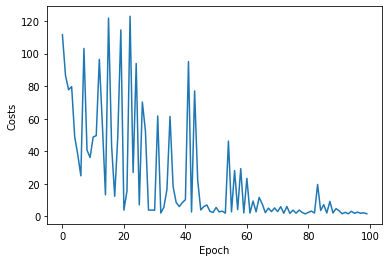

In [15]:
fig = plt.figure()
plt.plot([i for i in range(len(costs))], costs)
plt.xlabel('Epoch')
plt.ylabel('Costs')
plt.show()
#plt.savefig('./qcl-epoch.png')

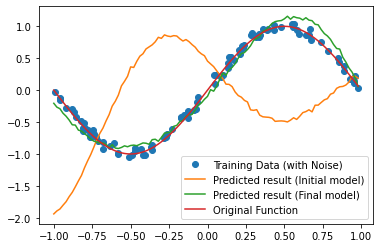

In [16]:
fig = plt.figure()
plt.plot(x_train, y_train, "o", label='Training Data (with Noise)')
plt.plot(x_pred, y_pred_reg_init, label='Predicted result (Initial model)')
plt.plot(x_pred, y_pred_reg_final, label='Predicted result (Final model)')
plt.plot(x_pred, y_pred, label='Original Function')
plt.legend()
plt.show()
#plt.savefig('./qcl-regplot.png')